# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [2]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [3]:
rules_data_path = 'data/rules.tsv.xz'                       # You do not need to decompress this yourself. Pandas understands how to read compressed data.

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,                           # This disables interpretation of quotes by Pandas itself, because both single and double quotes will be resolved by literal_eval.
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval # This reads something like ["Grandma's 8\" Chip Cookies", '6" Apple Pie'] into a list, so you will get a column where each individual cell is a list.
                       },
                       low_memory=True)                     # For Chris

But just *how* many rules were just loaded‽

In [4]:
# Show the list of column names and the number of rules.
print(df_rules.columns, len(df_rules), sep="\n\n\n")


Index(['consequent_item', 'transaction_count', 'item_set_count',
       'antecedent_count', 'consequent_count', 'antecedent_items'],
      dtype='object')


1048575


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [37]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

df_rules["support"] = df_rules["item_set_count"] / df_rules["transaction_count"]
df_rules["confidence"] = df_rules["item_set_count"] / df_rules["antecedent_count"]
df_rules["lift"] = df_rules["item_set_count"] / df_rules['antecedent_count'] / (
    df_rules["consequent_count"] / df_rules['transaction_count']
)

print(df_rules.head(50))# Something goes here.

0          21465.598514
1          21465.598514
2          21465.598514
3          21465.598514
4          21465.598514
               ...     
1048570        1.000000
1048571        1.000000
1048572        1.000000
1048573        1.000000
1048574        1.000000
Name: lift, Length: 1048575, dtype: float64

The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*I think that the yougurt has a lot of lift because the yougurts are being purchased together*

In [6]:
# Query the rule set if you have to to find out more.
high_lift_rules = df_rules[df_rules["lift"] > 9000]
high_lift_items = high_lift_rules[
    ["consequent_item", "antecedent_count", "consequent_count"]
]
print(high_lift_items)

                                         consequent_item  antecedent_count  \
0      Total 2% with Raspberry Pomegranate Lowfat Gre...               123   
1      Total 2% Lowfat Greek Strained Yogurt With Blu...               128   
2       Total 0% with Honey Nonfat Greek Strained Yogurt               123   
3                              Total 0% Raspberry Yogurt               123   
4                                    Pineapple Yogurt 2%               128   
...                                                  ...               ...   
10315   Total 0% with Honey Nonfat Greek Strained Yogurt               361   
10316                          Total 0% Raspberry Yogurt               361   
10317                                Pineapple Yogurt 2%               104   
10318                         Fat Free Strawberry Yogurt               104   
10319                          Fat Free Blueberry Yogurt               361   

       consequent_count  
0                   128  
1          

## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [68]:
# Define df_rules_subset.

# df_rules_subset =
df_rules_conditional = (
    (df_rules["antecedent_items"].apply(lambda x: len(x) == 1))
    & ((df_rules["lift"] >= 5) & (df_rules["lift"] <= 20))
    & (
        (
            df_rules["consequent_item"].apply(lambda x: "Hummus" in x)
            & ~(df_rules["antecedent_items"].apply(lambda x: "Hummus" in x))
        )
        | (
            ~(df_rules["consequent_item"].apply(lambda x: "Hummus" in x))
            & df_rules["antecedent_items"].apply(lambda x: "Hummus" in x)
        )
    )
)

df_rules_subset = df_rules[df_rules_conditional]
df_rules_subset["consequent_item"] = df_rules_subset["consequent_item"].apply(
    lambda x: "Hummus" if "Hummus" in x else str(x[0])
)

df_rules_subset["antecedent_items"] = df_rules_subset["antecedent_items"].apply(
    lambda x: str(x[0])
)

df_rules_subset
# df_rules
# Something goes here. You can repeat this for as many steps as necessary. Technically, you can do it all in one shot. :)

/tmp/ipykernel_3360/2996852053.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_subset["consequent_item"] = df_rules_subset["consequent_item"].apply(
/tmp/ipykernel_3360/2996852053.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_subset["antecedent_items"] = df_rules_subset["antecedent_items"].apply(


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
416420,Hummus,3346083,345,1656,74172,Organic White Pita Bread,0.000103,0.208333,9.398434
419119,Hummus,3346083,293,1434,74172,Organic Whole Wheat Pita,0.000088,0.204324,9.217543
422178,Hummus,3346083,331,1655,74172,Mini Whole Wheat Pita Bread,0.000099,0.200000,9.022496
440198,Hummus,3346083,3119,17333,74172,Sea Salt Pita Chips,0.000932,0.179946,8.117800
463035,Hummus,3346083,151,933,74172,"Lentil Chips, Himalayan Pink Salt",0.000045,0.161844,7.301163
463988,Hummus,3346083,311,1929,74172,Garbanzo Beans No Salt Added,0.000093,0.161223,7.273189
476420,Hummus,3346083,512,3333,74172,Organic Whole Peeled Baby Carrots,0.000153,0.153615,6.929970
506520,Hummus,3346083,168,1208,74172,Baba Ghannouge Eggplant Dip,0.000050,0.139073,6.273921
519416,Hummus,3346083,117,875,74172,Sonoma Organic Wraps Multigrain Tortillas With...,0.000035,0.133714,6.032183
523791,Hummus,3346083,1544,11702,74172,Pita Chips Simply Naked,0.000461,0.131943,5.952288


Build a network `graph_rules_subset` from the association rules subset.

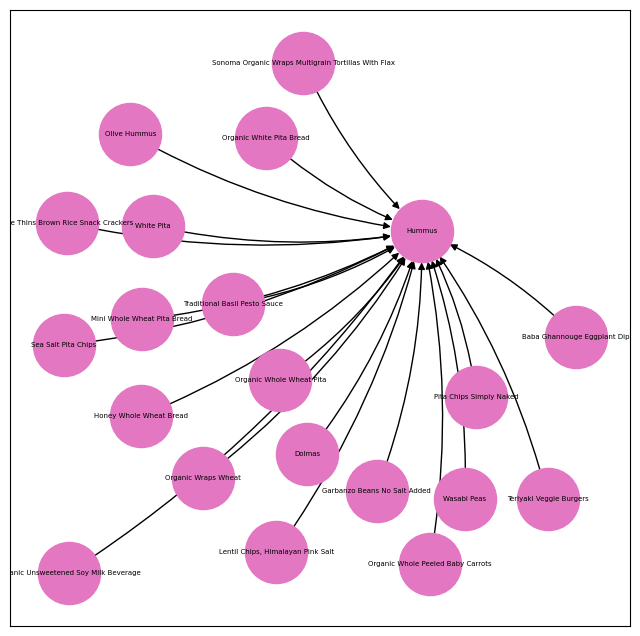

In [100]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

graph_rules_subset = nx.MultiDiGraph()
from_nodes = df_rules_subset['antecedent_items']
to_nodes = df_rules_subset['consequent_item']
cxns = zip(from_nodes, to_nodes)
graph_rules_subset.add_edges_from(cxns)

# Then render the graph.
plt.figure(1, figsize=(8, 8))
nx.draw_networkx(
    graph_rules_subset,
    arrows=True,
    node_size=2000,
    font_size=5,
    node_color="tab:pink",
    font_color="black",
    connectionstyle="arc3, rad=0.1",
)

What can you tell about people who buy hummus?

*It's usually bought with breads, dips, or other ingredients*

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [104]:
basket = {"Orange Bell Pepper", "Organic Red Bell Pepper"}
condition1 = df_rules["antecedent_items"].apply(lambda x: "Orange Bell Pepper" in x)
condition2 = df_rules["antecedent_items"].apply(
    lambda x: "Organic Red Bell Pepper" in x
)

df_rules[  # A few conditions go here which takes care of all the following cases:
    # * Just Orange Bell Pepper
    # * Just Organic Red Bell Pepper
    # * Both Orange Bell Pepper and Organic Red Bell Pepper
    # You can do it using just 2 conditions. :)
    condition1
    | condition2
].sort_values("lift", ascending=False).head(20)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
342462,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,100,209,19962,"[Nonfat Icelandic Style Strawberry Yogurt, Ora...",0.000030,0.478469,80.202217
345882,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,132,311,19962,"[Non Fat Raspberry Yogurt, Orange Bell Pepper]",0.000039,0.424437,71.145298
346832,Nonfat Icelandic Style Strawberry Yogurt,3346083,100,441,11025,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000030,0.226757,68.820769
346901,Non Fat Raspberry Yogurt,3346083,184,529,16953,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000055,0.347826,68.651858
349532,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,184,494,19962,"[Non Fat Raspberry Yogurt, Organic Red Bell Pe...",0.000055,0.372470,62.434341
350852,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,167,471,19962,"[Organic Red Bell Pepper, Vanilla Skyr Nonfat ...",0.000050,0.354565,59.433078
350991,Non Fat Raspberry Yogurt,3346083,132,441,16953,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000039,0.299320,59.077960
351360,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,101,291,19962,"[Nonfat Icelandic Style Strawberry Yogurt, Org...",0.000030,0.347079,58.178302
351433,Nonfat Icelandic Style Strawberry Yogurt,3346083,101,529,11025,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000030,0.190926,57.946047
351881,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,133,392,19962,"[Orange Bell Pepper, Vanilla Skyr Nonfat Yogurt]",0.000040,0.339286,56.871965


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.